## Predicting tweet sentiments

### Problem Statement

You work in an event management company. On Mother's Day, your company has organized an event where they want to cast positive Mother's Day related tweets in a presentation. Data engineers have already collected the data related to Mother's Day that must be categorized into positive, negative, and neutral tweets.

You are appointed as a Machine Learning Engineer for this project. Your task is to build a model that helps the company classify these sentiments of the tweets into positive, negative, and neutral.

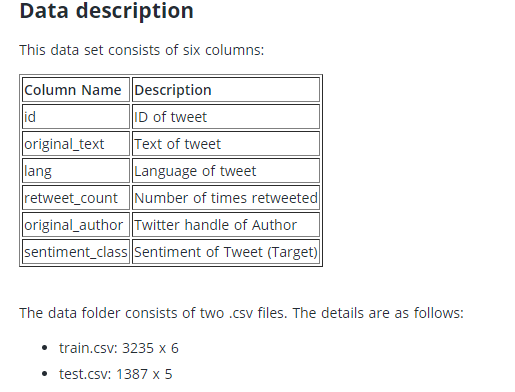

#### importing useful libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from nltk.stem import PorterStemmer 

import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize 

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn import preprocessing
import os
import math

import warnings
warnings.filterwarnings('ignore')

C:\Users\User\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Loading datasets

In [3]:
train_original = pd.read_csv('train.csv')
test_original = pd.read_csv('test.csv')

In [4]:
train = train_original.copy()
test = test_original.copy()

In [5]:
train.shape

(3235, 6)

In [6]:
test.shape

(1387, 5)

In [7]:
train.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class
0,1.245025e+18,Happy #MothersDay to all you amazing mothers o...,en,0,BeenXXPired,0
1,1.245759e+18,Happy Mothers Day Mum - I'm sorry I can't be t...,en,1,FestiveFeeling,0
2,1.246087e+18,Happy mothers day To all This doing a mothers ...,en,0,KrisAllenSak,-1
3,1.244803e+18,Happy mothers day to this beautiful woman...ro...,en,0,Queenuchee,0
4,1.244876e+18,Remembering the 3 most amazing ladies who made...,en,0,brittan17446794,-1


### Exploratory Data Analysis

In [8]:
import pandas_profiling
profile = pandas_profiling.ProfileReport(train, title='Pandas Profiling Report For Train Dataset', html={'style':{'full_width':True}})

In [ ]:
profile.to_file(output_file="trainData_report.html")
## output file has been saved as 'trainData_report.html'

In [10]:
train.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class
0,1.245025e+18,Happy #MothersDay to all you amazing mothers o...,en,0,BeenXXPired,0
1,1.245759e+18,Happy Mothers Day Mum - I'm sorry I can't be t...,en,1,FestiveFeeling,0
2,1.246087e+18,Happy mothers day To all This doing a mothers ...,en,0,KrisAllenSak,-1
3,1.244803e+18,Happy mothers day to this beautiful woman...ro...,en,0,Queenuchee,0
4,1.244876e+18,Remembering the 3 most amazing ladies who made...,en,0,brittan17446794,-1


In [11]:
train_tweet = np.asarray(list(train['original_text']))
test_tweet = np.asarray(list(test['original_text']))

In [12]:
type(train_tweet)

numpy.ndarray

## text_preprocessing

In [13]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [14]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [15]:
from tqdm import tqdm
preprocessed_tweets = []
# tqdm is for printing the status bar
for sentance in tqdm(train_tweet):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_tweets.append(sentance.strip())

100%|████████████████████████████████████| 3235/3235 [00:02<00:00, 1397.78it/s]


In [16]:
train_tweet = preprocessed_tweets

In [17]:
train_tweet[0]

'happy mothersday amazing mothers know hard not able see mothers today us protect vulnerable members society beatcoronavirus'

In [18]:
from tqdm import tqdm
preprocessed_tweets = []
# tqdm is for printing the status bar
for sentance in tqdm(test_tweet):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_tweets.append(sentance.strip())

100%|████████████████████████████████████| 1387/1387 [00:01<00:00, 1320.88it/s]


In [19]:
test_tweet[0]

'3. Yeah, I once cooked potatoes when I was 3 years old, and by that I mean I threw a bag of spuds into the toilet. " Happy mothers day , I made breakfast!" 66. That time I thought I was cool by drawing the naked lady dachshund on the overhead projector in psychology class. 8'

In [20]:
test_tweet = preprocessed_tweets

In [21]:
test_tweet[0]

'yeah cooked potatoes years old mean threw bag spuds toilet happy mothers day made breakfast time thought cool drawing naked lady dachshund overhead projector psychology class'

## stemming

In [22]:
def PorterStemming(lines):
    ps = PorterStemmer()
    word_token = word_tokenize(lines)
    stem_sentence=[]
    
    for w in word_token:
        stem_sentence.append(ps.stem(w))
        stem_sentence.append(" ")
    
    return " ".join(stem_sentence)

In [23]:
stem_tweet = []
for tweet in train_tweet:
    x = PorterStemming(tweet)
    stem_tweet.append(x)

In [24]:
train_tweet[0]

'happy mothersday amazing mothers know hard not able see mothers today us protect vulnerable members society beatcoronavirus'

In [25]:
train_tweet = stem_tweet

In [26]:
train_tweet[0]

'happi   mothersday   amaz   mother   know   hard   not   abl   see   mother   today   us   protect   vulner   member   societi   beatcoronaviru  '

In [27]:
stem_tweet = []
for tweet in test_tweet:
    x = PorterStemming(tweet)
    stem_tweet.append(x)

In [28]:
test_tweet[0]

'yeah cooked potatoes years old mean threw bag spuds toilet happy mothers day made breakfast time thought cool drawing naked lady dachshund overhead projector psychology class'

In [29]:
test_tweet = stem_tweet

In [30]:
test_tweet[0]

'yeah   cook   potato   year   old   mean   threw   bag   spud   toilet   happi   mother   day   made   breakfast   time   thought   cool   draw   nake   ladi   dachshund   overhead   projector   psycholog   class  '

### Lametization

In [31]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [32]:
lemmatizer = WordNetLemmatizer() 
# lemmatize string 
def lemmatize_word(text): 
    word_tokens = word_tokenize(text) 
    # provide context i.e. part-of-speech 
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens] 
    return lemmas 

In [33]:
lam_tweet = []
for tweet in train_tweet:
    x = lemmatize_word(tweet)
    tweet = " ".join(x)
    lam_tweet.append(tweet)


In [34]:
train_tweet[0]

'happi   mothersday   amaz   mother   know   hard   not   abl   see   mother   today   us   protect   vulner   member   societi   beatcoronaviru  '

In [35]:
train_tweet = lam_tweet

In [36]:
train_tweet[0]

'happi mothersday amaz mother know hard not abl see mother today us protect vulner member societi beatcoronaviru'

In [37]:
lam_tweet = []
for tweet in test_tweet:
    x = lemmatize_word(tweet)
    tweet = " ".join(x)
    lam_tweet.append(tweet)

In [38]:
test_tweet = lam_tweet

## Word2Vec

In [39]:
list_of_Train_sent=[]
list_of_Test_sent=[]

for sent in train_tweet:
    list_of_Train_sent.append(sent.split())
    
for sent in test_tweet:
    list_of_Test_sent.append(sent.split())

In [40]:
w2v_model=KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)


In [41]:
import numpy as np

Train_vectors = []
for sent in list_of_Train_sent:
    sent_vec = np.zeros(300)
    cnt_words = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    if cnt_words!=0:    
        sent_vec /= cnt_words
    Train_vectors.append(sent_vec)
Train_vectors = np.nan_to_num(Train_vectors)

print("Shape of Train Vectors : ",Train_vectors.shape)

Shape of Train Vectors :  (3235, 300)


In [42]:
Test_vectors=[]
for sent in list_of_Test_sent:
    sent_vec=np.zeros(300)
    cnt_words=0
    for word in sent:
        try:
            vec=w2v_model.wv[word]
            sent_vec+=vec
            cnt_words+=1
        except:
            pass
    if cnt_words!=0:
        sent_vec/=cnt_words
    Test_vectors.append(sent_vec)
Test_vectors=np.nan_to_num(Test_vectors)   

print("Shape of Test Vectors : ",Test_vectors.shape)

Shape of Test Vectors :  (1387, 300)


In [43]:
train_tweet_av_w2v = Train_vectors
test_tweet_av_w2v = Test_vectors

## TF-IDF Word2Vec

In [44]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(train_tweet)

X_train_tfidf = model.transform(train_tweet)
X_test_tfidf = model.transform(test_tweet)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [45]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3000000
sample words  ['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said', 'was', 'the', 'at', 'not', 'as', 'it', 'be', 'from', 'by', 'are', 'I', 'have', 'he', 'will', 'has', '####', 'his', 'an', 'this', 'or', 'their', 'who', 'they', 'but', '$', 'had', 'year', 'were', 'we', 'more', '###', 'up', 'been', 'you', 'its', 'one', 'about', 'would', 'which', 'out']


In [46]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

train_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_Train_sent): # for each review/sentence 
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████| 3235/3235 [29:04<00:00,  1.85it/s]


In [47]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_Test_sent): # for each review/sentence 
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████| 1387/1387 [11:57<00:00,  1.93it/s]


In [48]:
train_tweet_tfidf_w2v =np.nan_to_num(train_tfidf_sent_vectors) 
test_tweet_tfidf_w2v =np.nan_to_num(test_tfidf_sent_vectors)

In [49]:
type(train_tweet_tfidf_w2v)

numpy.ndarray

In [50]:
type(train_tweet_av_w2v)

numpy.ndarray

In [51]:
train_tweet_tfidf_w2v_df = pd.DataFrame(train_tweet_tfidf_w2v)

In [52]:
train_tweet_tfidf_w2v_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.013272,-0.046192,0.013292,0.057042,-0.120218,0.063735,0.064546,-0.066017,0.071627,-0.018405,...,-0.000690,0.042961,-0.115856,-0.051092,-0.113489,0.010326,-0.013493,0.005096,0.088509,-0.049765
1,-0.034284,0.046894,0.019561,0.142132,-0.053285,-0.071884,0.073748,-0.115451,-0.003434,0.091652,...,-0.043659,0.023384,-0.060533,0.000434,0.015738,-0.021155,-0.023114,-0.048888,0.021127,0.003741
2,0.001154,0.025893,-0.025144,0.060305,-0.077366,0.011482,0.073447,-0.121171,0.080558,0.076344,...,-0.027087,0.052895,-0.076283,-0.015105,-0.030569,-0.078503,0.005025,-0.005411,0.071961,0.010955
3,0.000701,0.088502,-0.039560,-0.001807,0.001125,0.077518,0.009237,-0.088241,-0.039057,0.138953,...,-0.034683,-0.187994,-0.044528,-0.031775,0.078682,0.051348,-0.107455,0.080033,0.065011,-0.089328
4,0.019057,0.016400,0.024815,0.129743,-0.016523,-0.005523,0.016260,-0.109885,0.047486,0.084969,...,0.038360,0.059489,-0.133066,-0.033280,-0.084382,-0.103801,-0.031252,-0.099720,-0.017788,-0.037329


In [53]:
test_tweet_tfidf_w2v_df = pd.DataFrame(test_tweet_tfidf_w2v)

In [54]:
test_tweet_tfidf_w2v_df.shape

(1387, 300)

In [55]:
train_tweet_av_w2v_df = pd.DataFrame(train_tweet_av_w2v)
test_tweet_av_w2v_df = pd.DataFrame(test_tweet_av_w2v)

In [56]:
train_tweet_av_w2v_df.shape

(3235, 300)

In [57]:
train.shape

(3235, 6)

In [58]:
av_train = pd.concat([train, train_tweet_av_w2v_df], axis=1, sort=False)
av_test = pd.concat([test, test_tweet_av_w2v_df], axis=1, sort=False)

In [59]:
av_train.shape

(3235, 306)

In [60]:
idf_train = pd.concat([train, train_tweet_tfidf_w2v_df], axis=1, sort=False)
idf_test = pd.concat([test, test_tweet_tfidf_w2v_df], axis=1, sort=False)

In [61]:
av_train.to_csv('av_train.csv',index=False)

In [62]:
av_test.to_csv('av_test.csv',index=False)

In [63]:
idf_train.to_csv('idf_train.csv',index=False)

In [64]:
idf_test.to_csv('idf_test.csv',index=False)

In [65]:
df = pd.read_csv('av_train.csv')

In [66]:
df.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class,0,1,2,3,...,290,291,292,293,294,295,296,297,298,299
0,1.245025e+18,Happy #MothersDay to all you amazing mothers o...,en,0,BeenXXPired,0,0.006416,-0.055166,0.014640,0.057922,...,-0.014150,0.036896,-0.119891,-0.061339,-0.082811,-0.000542,-0.015177,-0.012628,0.084066,-0.048818
1,1.245759e+18,Happy Mothers Day Mum - I'm sorry I can't be t...,en,1,FestiveFeeling,0,-0.024468,0.029493,0.017522,0.130514,...,-0.041716,0.013131,-0.093417,-0.025698,-0.008742,-0.025610,-0.038935,-0.047493,0.028866,-0.002012
2,1.246087e+18,Happy mothers day To all This doing a mothers ...,en,0,KrisAllenSak,-1,-0.015384,0.021916,-0.014945,0.065484,...,-0.030707,0.044758,-0.094112,-0.021941,-0.024084,-0.065188,-0.013745,0.000598,0.070435,0.001779
3,1.244803e+18,Happy mothers day to this beautiful woman...ro...,en,0,Queenuchee,0,-0.009273,0.023655,-0.021606,0.004464,...,-0.009068,-0.094727,-0.098598,-0.065059,0.011893,0.027967,-0.084996,0.036227,0.062762,-0.035108
4,1.244876e+18,Remembering the 3 most amazing ladies who made...,en,0,brittan17446794,-1,0.010554,-0.002386,0.022061,0.105533,...,0.044184,0.067835,-0.118322,-0.053866,-0.073320,-0.110515,-0.025973,-0.087958,-0.014474,-0.035879


We have saved the csv files and now we will continue our modeling in the new notebook